#installs

In [ ]:
!pip install qiskit
!pip install qiskit_algorithms
!pip install pylatexenc
!pip install qiskit_machine_learning
!pip install qiskit_aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=863a981ebc23c52440e9dd67c9116630eb88bf08537932dc3ff24dc402345305
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from math import sin, cos, pi
import matplotlib.pyplot as plt
from google.colab import files

import torch
from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS
from sklearn.model_selection import train_test_split

from qiskit import QuantumCircuit
from qiskit_machine_learning.optimizers import COBYLA

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit.library import ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import StatevectorEstimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_aer import AerSimulator
from scipy.optimize import minimize

# Drive Import

In [ ]:
# @title
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
# @title
feature = [ 'SUSY','lepton 1 pT', 'lepton 2 pT', 'missing energy magnitude']

root_dir = '/content/drive/MyDrive/susy/'
data_file = 'SUSY.csv.gz'
df_nn = pd.read_csv(root_dir + data_file, usecols=[0, 1, 4,7])
df_nn.columns = feature

# Uploading Dataset

In [ ]:
features = [ 'lepton 1 pT', 'lepton 2 pT', 'missing energy magnitude','SUSY']
# features=['SUSY', 'lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT',
#        'lepton 2 eta', 'lepton 2 phi', 'missing energy magnitude',
#        'missing energy phi', 'MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R',
#        'MT2', 'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']

# root_dir = '/content/drive/MyDrive/susy/'
# data_file = 'SUSY.csv.gz'
# df = pd.read_csv(root_dir + data_file, usecols=[0, 1, 4, 7,12,16])
# mdf = pd.read_csv('/content/highly_correlated_data.csv')

df = pd.read_csv('/content/susy_1000.csv')
df.columns = features


# Correlation Matrix

Correlation Matrix:
                          lepton 1 pT  lepton 2 pT  missing energy magnitude
lepton 1 pT                  1.000000     0.672293                  0.352901
lepton 2 pT                  0.672293     1.000000                  0.141759
missing energy magnitude     0.352901     0.141759                  1.000000


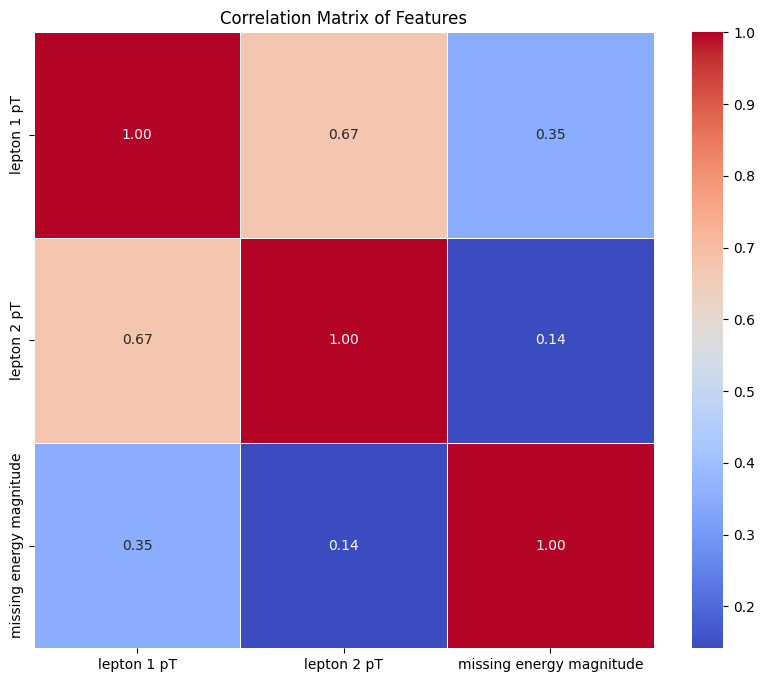

In [ ]:
data_only = df.drop(columns=['SUSY'])

# Compute the correlation matrix
correlation_matrix = data_only.corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

#Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()


# Scaling from [-1,1] and [-2pi,2pi]

In [ ]:
def min_max_scaling(x,axis=None):
  """Normalized to [-1, 1]"""
  min = x.min(axis=axis)
  max = x.max(axis=axis)
  result = (x-min)/(max-min)
  result = 2.0*result-1.0
  return result

In [ ]:
def min_max_scaling_pi(x,axis=None):
  """Normalized to [-2*pi, 2*pi]"""
  min = x.min(axis=axis)
  max = x.max(axis=axis)
  result = (x-min)/(max-min)
  result = result * (2 * np.pi) * 2 - (2 * np.pi)
  return result

In [ ]:
df.head()

,lepton 1 pT,lepton 2 pT,missing energy magnitude,SUSY
0,1.742754,1.423210,1.831006,1.0
1,0.766916,0.827923,2.636657,1.0
2,0.658630,0.843965,0.103182,1.0
3,0.613593,0.875340,0.387255,0.0
4,0.680474,1.116256,0.735401,0.0


# Features and Labels

In [ ]:
raw_X = df.drop(columns=['SUSY'])
# raw_X = raw_X.astype(np.complex128)
features = min_max_scaling(raw_X.values)
Y = df['SUSY']
labels = Y.values


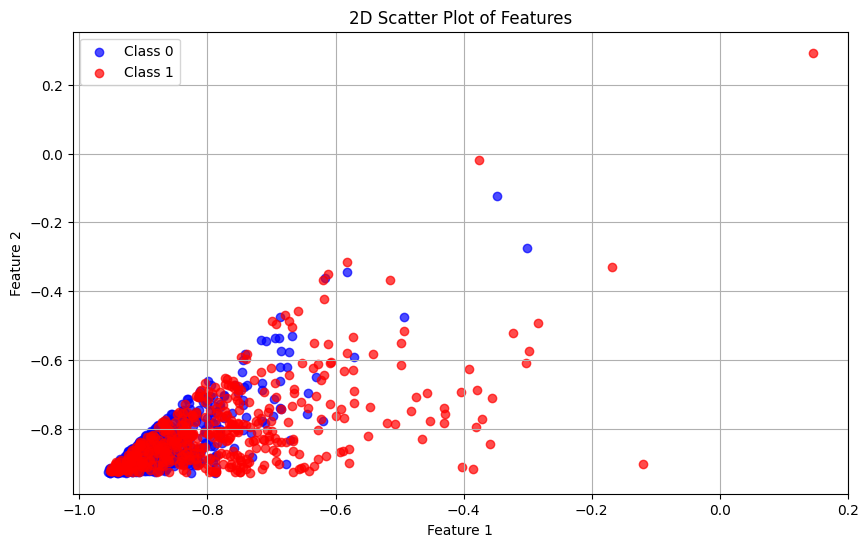

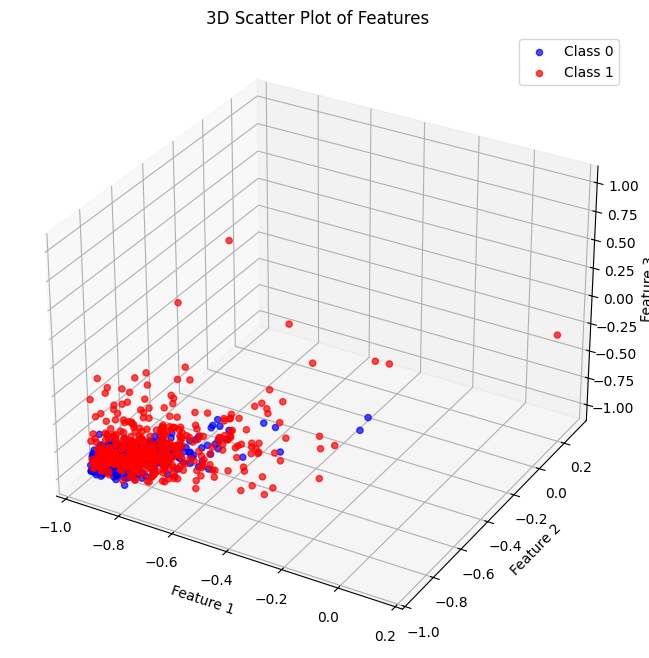

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Assuming `features` is a scaled NumPy array and `labels` is a NumPy array
# Extract individual features
feature1 = features[:, 0]
feature2 = features[:, 1]
feature3 = features[:, 2]
labels = labels.astype(int)  # Ensure labels are integers for plotting

# Separate the data based on labels
class_0 = features[labels == 0]
class_1 = features[labels == 1]

# 2D Plot (Feature 1 vs. Feature 2)
plt.figure(figsize=(10, 6))
plt.scatter(class_0[:, 0], class_0[:, 1], color='blue', label='Class 0', alpha=0.7)
plt.scatter(class_1[:, 0], class_1[:, 1], color='red', label='Class 1', alpha=0.7)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('2D Scatter Plot of Features')
plt.legend()
plt.grid(True)
plt.show()

# 3D Plot (Feature 1 vs. Feature 2 vs. Feature 3)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(class_0[:, 0], class_0[:, 1], class_0[:, 2], color='blue', label='Class 0', alpha=0.7)
ax.scatter(class_1[:, 0], class_1[:, 1], class_1[:, 2], color='red', label='Class 1', alpha=0.7)
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.set_title('3D Scatter Plot of Features')
ax.legend()
plt.show()


# Variational Circuit

In [ ]:
theta1 = Parameter("a")
theta2 = Parameter("b")
theta3 = Parameter("c")
theta4 = Parameter("d")
theta5 = Parameter("e")
theta6 = Parameter("f")
theta7 = Parameter("g")
theta8 = Parameter("h")
theta9 = Parameter("i")
theta10 = Parameter("j")
theta11 = Parameter("k")
theta12 = Parameter("l")


def var_circ():
  qc = QuantumCircuit(3)
  n = qc.num_qubits
  qc.ry(theta1,0)
  qc.rz(theta4,0)
  qc.ry(theta2,1)
  qc.rz(theta5,1)
  qc.ry(theta3,2)
  qc.rz(theta6,2)
  qc.h(1)
  qc.cx(0,1)
  qc.h(1)
  qc.barrier()
  qc.h(2)
  qc.cx(0,2)
  qc.h(2)
  qc.barrier()
  qc.h(2)
  qc.cx(1,2)
  qc.h(2)
  qc.barrier()
  qc.ry(theta7,0)
  qc.rz(theta10,0)
  qc.ry(theta8,1)
  qc.rz(theta11,1)
  qc.ry(theta9,2)
  qc.rz(theta12,2)
  return qc

# Encoding Circuit

In [ ]:
input1 = Parameter("u")
input2 = Parameter("v")
input3 = Parameter("x")
input4 = Parameter("y")
input5 = Parameter("z")

def qnn_encoding():
  qc = QuantumCircuit(3)
  n = qc.num_qubits
  # Encoding circuit
  for i in range(n):
    qc.h(i)
  qc.rz(input1,0)
  qc.rz(input2,1)
  qc.rz(input3,2)
  # qc.rz(input4,3)
  # qc.rz(input5,4)
  return qc

# Building Estimator QNN

In [ ]:
ansatz_qnn = RealAmplitudes(3, reps=2)
prep = ZZFeatureMap(3, reps=1)

def circ_qnn():
  qc = QuantumCircuit(3)
  mapping = qnn_encoding()
  # mapping = prep
  ansatz = var_circ()
  # ansatz_ = ansatz_qnn
  encoder = qc.compose(mapping)
  classifier = encoder.compose(ansatz)
  return classifier

In [ ]:
qnn = EstimatorQNN(
    circuit=circ_qnn(), input_params=qnn_encoding().parameters, weight_params=var_circ().parameters)

<ipython-input-12-86b2dbf57967>:1: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


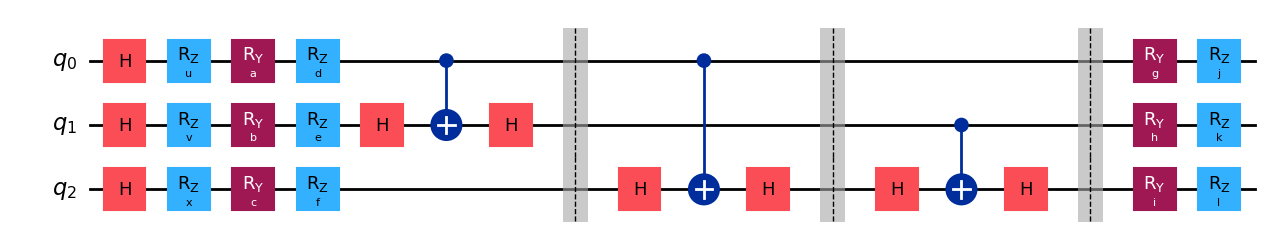

In [ ]:
# print(qnn.circuit)
qnn.circuit.draw("mpl")

# Initialising Weights for Training

In [ ]:
initial_weights = (2 * algorithm_globals.random.random(qnn.num_weights) - 1)
model1 = TorchConnector(qnn, initial_weights=initial_weights)
print("Initial weights: ", initial_weights)

Initial weights:  [-0.18046984 -0.72297027 -0.73813719 -0.43836368  0.89649977  0.74773864
  0.51511099 -0.25479931 -0.15190324 -0.3266806  -0.44962129 -0.30291432]


In [ ]:
labels_=Tensor(labels).reshape(len(labels), 1)
model1(Tensor(features[0, :]))



tensor([-0.3533], grad_fn=<_TorchNNFunctionBackward>)

In [ ]:
labels_[3,:]

tensor([0.])

In [ ]:
optimizer = LBFGS(model1.parameters())
f_loss = MSELoss(reduction="sum")

# Start training
model1.train()

TorchConnector()

In [ ]:
labels_=Tensor(labels).reshape(len(labels), 1)
def closure():
    optimizer.zero_grad()  # Initialize/clear gradients
    loss = f_loss(model1(Tensor(features)), labels_)  # Evaluate loss function
    loss.backward()  # Backward pass
    print(loss.item())  # Print loss
    return loss
    # Run optimizer step4
optimizer.step(closure)

342.32855224609375
299.966552734375
265.4307556152344
261.8189697265625
260.7039794921875
259.4547119140625
252.13845825195312
235.3219451904297
437.4914245605469
289.6527404785156
818.9849243164062
1592.46240234375
1633.8450927734375
305.40338134765625
379.73895263671875
344.39105224609375
527.3553466796875
440.2708740234375
573.010498046875
314.5622863769531


tensor(342.3286, grad_fn=<MseLossBackward0>)

In [ ]:
# import torch.optim as optim

# # Define the Adam optimizer with a specific learning rate
# learning_rate = 0.01  # Example learning rate
# betas = (0.9, 0.999)  # Default values for betas
# weight_decay = 0.001  # L2 regularization term

# optimizer = optim.Adam(model1.parameters(), lr=learning_rate, betas=betas, weight_decay=weight_decay)

# # Define the loss function
# f_loss = torch.nn.MSELoss(reduction="sum")

# # Training loop
# num_epochs = 100  # Number of training epochs
# labels_=Tensor(labels).reshape(len(labels), 1)
# for epoch in range(num_epochs):
#     def closure():
#         optimizer.zero_grad()  # Clear gradients
#         loss = f_loss(model1(Tensor(features)), labels_)  # Compute loss
#         loss.backward()  # Backward pass
#         print(f"Epoch {epoch+1}, Loss: {loss.item()}")  # Print loss
#         return loss

#     optimizer.step(closure)  # Update weights

In [ ]:
# learning_rates = [0.01, 0.001, 0.0001]
# betas_list = [(0.9, 0.999), (0.95, 0.999)]
# weight_decays = [0.0, 0.001, 0.01]

# for lr in learning_rates:
#     for beta in betas_list:
#         for wd in weight_decays:
#             print(f"Training with lr={lr}, betas={beta}, weight_decay={wd}")

#             # Reinitialize model weights
#             initial_weights = (2 * algorithm_globals.random.random(qnn.num_weights) - 1)
#             model1 = TorchConnector(qnn, initial_weights=initial_weights)

#             # Define optimizer with current hyperparameters
#             optimizer = optim.Adam(model1.parameters(), lr=lr, betas=beta, weight_decay=wd)

#             # Training loop
#             for epoch in range(num_epochs):
#                 def closure():
#                     optimizer.zero_grad()
#                     loss = f_loss(model1(Tensor(features)), labels_)
#                     loss.backward()
#                     return loss

#                 optimizer.step(closure)

#             # Evaluate model performance (e.g., on a validation set)
#             # Store or print results for comparison

In [ ]:
model1.eval()
y_predict = []
y_pred_prob = []
threshold = 0.5

for x, y_target in zip(features, labels):
    # Forward pass: get model output
    output = model1(Tensor(x))
    # print(output)
    # Store the predicted probability
    y_pred_prob.append(output.detach().numpy()[0])

    # Convert the output probability to a binary prediction using the threshold
    binary_prediction = 1 if output.detach().numpy()[0] >= threshold else 0
    y_predict.append(binary_prediction)

# Calculate accuracy
accuracy = sum(np.array(y_predict) == np.array(labels)) / len(labels)
print("Accuracy:", accuracy)

Accuracy: 0.548


In [ ]:
y_predict

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


[inf  0.]


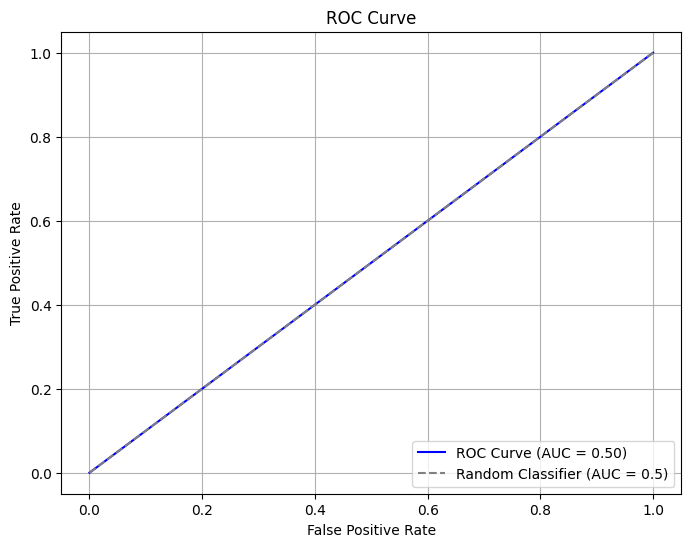

AUC Score: 0.5


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Evaluate the model to get predicted probabilities
# model1.eval()  # Set the model to evaluation mode
# y_pred_prob = []

# for x in features:
#     output = model1(Tensor(x))  # Get model predictions
#     y_pred_prob.append(output.detach().numpy()[0])  # Collect the probabilities

# Convert to NumPy array
y_predict = np.array(y_predict)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(labels, y_predict)
# print(np.mean(fpr))
# print(np.mean(tpr))
print(thresholds)
roc_auc_1 = auc(fpr, tpr)

# # Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc_1:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Print the AUC score
print("AUC Score:", roc_auc_1)


In [ ]:
labels

array([1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1.,
       0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
       0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0.,
       1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0.])

In [ ]:
def calculate_tpr_fpr(y_true, y_predict):
    """
    Calculate True Positive Rate (TPR) and False Positive Rate (FPR) for a fixed threshold.

    Args:
        y_true (list): List of true binary labels (0 or 1).
        y_predict (list): List of predicted binary labels (0 or 1).

    Returns:
        TPR (float): True Positive Rate.
        FPR (float): False Positive Rate.
    """
    # Calculate True Positives (TP), False Positives (FP), True Negatives (TN), False Negatives (FN)
    TP = sum((true == 1 and pred == 1) for true, pred in zip(y_true, y_predict))
    FP = sum((true == 0 and pred == 1) for true, pred in zip(y_true, y_predict))
    TN = sum((true == 0 and pred == 0) for true, pred in zip(y_true, y_predict))
    FN = sum((true == 1 and pred == 0) for true, pred in zip(y_true, y_predict))

    # Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
    TPR = TP / (TP + FN) if (TP + FN) != 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) != 0 else 0

    return TPR, FPR ,TP, FP, TN, FN




# Calculate TPR and FPR
TPR, FPR,TP, FP, TN, FN = calculate_tpr_fpr(labels, y_predict)
print(f"True Positive Rate (TPR): {TPR:.2f}")
print(f"False Positive Rate (FPR): {FPR:.2f}")
print(f"True Positive (TP): {TP:.2f}")
print(f"False Positive (FP): {FP:.2f}")
print(f"True Negative (TN): {TN:.2f}")
print(f"False Negative (FN): {FN:.2f}")

True Positive Rate (TPR): 0.00
False Positive Rate (FPR): 0.00
True Positive (TP): 0.00
False Positive (FP): 0.00
True Negative (TN): 548.00
False Negative (FN): 452.00


In [ ]:
df['SUSY'].value_counts()

,count
SUSY,
0.0,113
1.0,87


# Other forms of Estimator QNN

In [ ]:
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.primitives import Estimator

from sklearn.preprocessing import OneHotEncoder
from torch import Tensor
from torch.nn import CrossEntropyLoss
from torch.optim import LBFGS
import numpy as np

qnn = EstimatorQNN(
    circuit=circ_qnn(),
    input_params=qnn_encoding().parameters,
    weight_params=var_circ().parameters

)

# Initialize weights
initial_weights = 2 * algorithm_globals.random.random(qnn.num_weights) - 1

# TorchConnector integrates the QNN with PyTorch
model1 = TorchConnector(qnn, initial_weights=initial_weights)
print("Initial weights: ", initial_weights)

# Optimizer and loss function
optimizer = LBFGS(model1.parameters())
f_loss = CrossEntropyLoss()

# One-hot encode labels for CrossEntropyLoss compatibility
labels_tensor =Tensor(labels).reshape(len(labels), 1)


# Start training
model1.train()

# Closure for optimization
def closure():
    optimizer.zero_grad()  # Initialize/clear gradients
    predictions = model1(Tensor(features))  # QNN predictions
    loss = f_loss(predictions, labels_tensor)  # Evaluate loss function
    loss.backward()  # Backward pass
    print("Loss:", loss.item())  # Print loss
    return loss

# Run the optimizer
optimizer.step(closure)

# Evaluation
model1.eval()
y_predict = []
for x, y_target in zip(features, labels):
    output = model1(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

# Calculate accuracy
accuracy = sum(y_predict == labels) / len(labels)
print("Accuracy:", accuracy)


<ipython-input-52-1a898a0ebf44>:11: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


Initial weights:  [-0.01739533 -0.4205241   0.69991448  0.71123777 -0.60471431  0.22671393
 -0.06733424  0.01496124 -0.71542642 -0.78072037 -0.0719285   0.62137441]
Loss: -0.0
Accuracy: 0.54


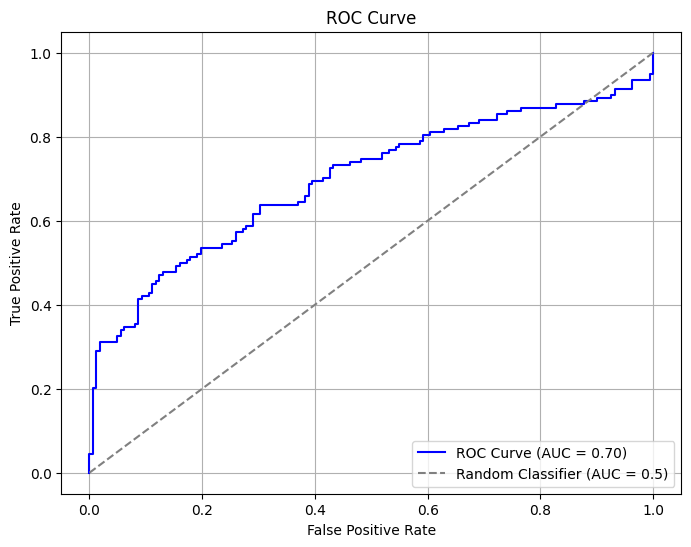

AUC Score: 0.6973966720343532


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Evaluate the model to get predicted probabilities
model1.eval()  # Set the model to evaluation mode
y_pred_prob = []

for x in features:
    output = model1(Tensor(x))  # Get model predictions
    y_pred_prob.append(output.detach().numpy()[0])  # Collect the probabilities

# Convert to NumPy array
y_pred_prob = np.array(y_pred_prob)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(labels_tensor, y_pred_prob)
roc_auc_1 = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc_1:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Print the AUC score
print("AUC Score:", roc_auc_1)


# Using different method

In [ ]:
def feature_map(x):
  qc = QuantumCircuit(3)
  n = qc.num_qubits
  # Encoding circuit
  for i in range(n):
    qc.h(i)
    qc.rz(x[i],i)
  return qc

In [ ]:
# def cost_func(params, list_coefficients, list_labels, obs, estimator, pm):
def cost_func(params, list_coefficients, list_labels, obs, estimator, pm, callback_dict):

    """Return cost function for optimization

    Parameters:
        params (ndarray): Array of ansatz parameters
        list_coefficients (list): List of arrays of complex coefficients
        list_labels (list): List of labels
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        obs (SparsePauliOp): Observable
        estimator (EstimatorV2): Statevector estimator primitive instance
        pm (PassManager): Pass manager
        callback_dict (dict): Dictionary to store callback information

    Returns:
        float: Cost function estimate
    """

    cost = 0
    for amplitudes,label in zip(list_coefficients, list_labels):
        qc = QuantumCircuit(3)
        mapping = feature_map(amplitudes)
        ansatz = var_circ()
        # Amplitude embedding
        encoder = qc.compose(mapping)
        # Compose initial state + ansatz
        classifier = encoder.compose(ansatz)
        # Transpile classifier
        transpiled_classifier = pm.run(classifier)
        # Transpile observable
        transpiled_obs = obs.apply_layout(layout=transpiled_classifier.layout)
        # Run estimator
        pub = (transpiled_classifier, transpiled_obs,params)
        job = estimator.run([pub])
        # Get result
        result = job.result()[0].data.evs
        # Compute cost function (cumulative)
        cost += np.abs(result - list_labels)

    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = params
    callback_dict["cost_history"].append(cost)

    # Print the iterations to screen on a single line
    # print(
    #     "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], cost),
    #     end="\r",
    #     flush=True,
    # )

    return np.sum(cost)

In [ ]:
# Generate the required arrays

num_parameters = 12
array1 = 2.3 * (2 * np.pi * algorithm_globals.random.random(num_parameters) - 1)
array5 =  1.3* algorithm_globals.random.random(num_parameters)  # Scaled random values
array2 = np.zeros(num_parameters)                            # All zeros
array3 = np.full(num_parameters, 1)                          # All twos
array4 = 0.1 * (2 *np.pi* algorithm_globals.random.random(12) - 1)
    # Random values between 0 and 1
# array5 = algorithm_globals.random.random(num_parameters)     # Another random array

# Combine them into the desired structure
result = np.array([array1, array2, array3, array4,array5])

In [ ]:
# Define the observable
obs = SparsePauliOp("ZZZ")
estimator = StatevectorEstimator() #To train we use StatevectorEstimator to get the exact simulation
pm = generate_preset_pass_manager(backend=AerSimulator(), optimization_level=1, seed_transpiler=0)

In [ ]:
cost_history_list = []
res_list = []

for it, params_0 in enumerate(result):

    print('Iteration number: ', it)

    # Initialize a callback dictionary
    callback_dict = {
        "prev_vector": None,
        "iters": 0,
        "cost_history": [],
    }

    # Minimize the cost function using scipy
    res = minimize(
        cost_func,
        params_0,
        args=(features, labels, obs, estimator, pm, callback_dict),
        method="cobyla", # Classical optimizer
        options={'maxiter': 200}) # Maximum number of iterations

    # Print the results after convergence
    print(res)

    # Save the results from different runs
    res_list.append(res)
    cost_history_list.append(callback_dict["cost_history"])

Iteration number:  0
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 17588.834166855828
       x: [ 1.142e+01  5.937e+00  1.143e+01  4.917e+00  8.943e+00
            1.004e+01  4.738e+00 -6.173e-01  1.653e+00  6.808e-02
            1.007e+01  1.018e+01]
    nfev: 200
   maxcv: 0.0
Iteration number:  1
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 17404.299830304317
       x: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00  2.394e-05  9.563e-05  1.681e-05  0.000e+00
            0.000e+00  0.000e+00]
    nfev: 125
   maxcv: 0.0
Iteration number:  2
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 17731.782988699662
       x: [ 1.124e+00  1.007e+00  3.644e-01  8.544e-01  4.901e-01
            7.904e-01  1.804e+00  8.084e-01  6.911e-01  1.007e+00
            9.856e-01  9.901e-01]
    nfev: 200
   maxcv: 0.0
I

In [ ]:
from re import U
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Prepare dataset
# feature = [ 'lepton 1 pT', 'lepton 2 pT', 'missing energy magnitude','SUSY']
# bdf = pd.read_csv('/content/susy_1000.csv')
# df.columns = feature
udf= df_nn.sample(n=10000,random_state = 42)
raw_X = udf.drop(columns=['SUSY'])
features_ = min_max_scaling(raw_X.values)  # Normalize the features
Y = udf['SUSY']
labels = Y.values

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(features_, labels, test_size=0.2, random_state=42)

### XGBoost Model
xgb_model = XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=42)
xgb_model.fit(X_train, y_train)  # Train the XGBoost model

# Make predictions and calculate accuracy for XGBoost
xgb_predictions = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")




/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:21:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.7505


In [ ]:
### Deep Neural Network (DNN) Model
udf= df_nn.sample(n=200,random_state = 42)
raw_X = udf.drop(columns=['SUSY'])
features_ = min_max_scaling(raw_X.values)  # Normalize the features
Y = udf['SUSY']
labels = Y.values

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(features_, labels, test_size=0.2, random_state=42)
# Define the DNN architecture
dnn_model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # For binary classification
])

# Compile the DNN model
dnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Train the DNN model
dnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the DNN model
dnn_loss, dnn_accuracy = dnn_model.evaluate(X_test, y_test, verbose=0)
print(f"DNN Accuracy: {dnn_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.4948 - loss: 0.7219 - val_accuracy: 0.6875 - val_loss: 0.6833
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4823 - loss: 0.6947 - val_accuracy: 0.6250 - val_loss: 0.6728
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5385 - loss: 0.6885 - val_accuracy: 0.5625 - val_loss: 0.6653
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5854 - loss: 0.6671 - val_accuracy: 0.5625 - val_loss: 0.6610
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5656 - loss: 0.6698 - val_accuracy: 0.5625 - val_loss: 0.6577
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5781 - loss: 0.6608 - val_accuracy: 0.5625 - val_loss: 0.6546
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6167 - loss: 0.6446 - val_accuracy: 0.5625 - val_loss: 0.6522
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5760 - loss: 0.6467 - val_accuracy: 0.5625 - val_loss: 0.6482

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


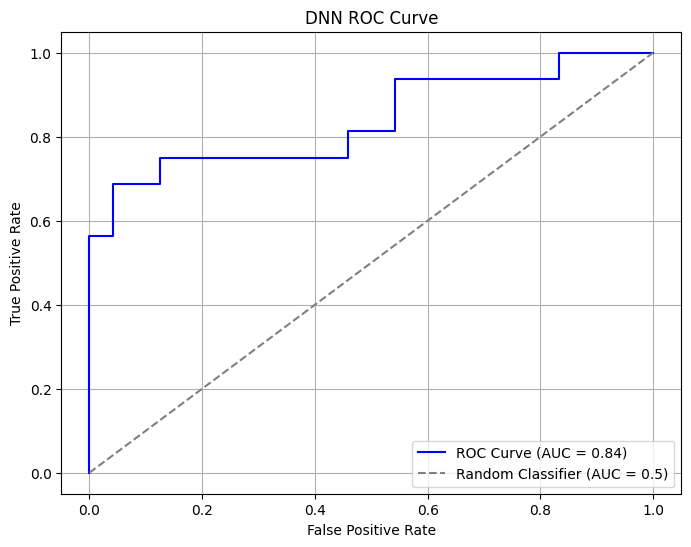

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for the test set
y_pred_prob = dnn_model.predict(X_test).ravel()  # Flatten the output to 1D

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Compute the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.title('DNN ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [ ]:
N_train_event = X_train.shape[0]
# Determine architecture based on N_train_event
if N_train_event <= 500:
    num_hidden_layers = 2
    num_nodes = 16
elif 500 < N_train_event <= 10_000:
    num_hidden_layers = 3
    num_nodes = 64
elif 10_000 < N_train_event <= 100_000:
    num_hidden_layers = 4
    num_nodes = 128
else:
    num_hidden_layers = 6
    num_nodes = 256

# Determine batch size
if N_train_event <= 10_000:
    batch_size = None  # Full-batch training
else:
    batch_size = 2048

# Define the DNN architecture
dnn_model = Sequential()
dnn_model.add(Dense(num_nodes, input_dim=X_train.shape[1], activation='relu'))  # Input layer

for _ in range(num_hidden_layers):  # Add hidden layers
    dnn_model.add(Dense(num_nodes, activation='relu'))

dnn_model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
dnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
dnn_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the DNN model
dnn_loss, dnn_accuracy = dnn_model.evaluate(X_test, y_test, verbose=0)
print(f"DNN Accuracy: {dnn_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NameError: name 'EarlyStopping' is not defined